In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from netCDF4 import Dataset
from netCDF4 import num2date
from mpl_toolkits.basemap import Basemap
import mpl_toolkits.basemap as basemap
import getpass

# Humboldt

## Datos Reanalisis

In [ ]:
t_ini=np.datetime64('1998-01-01T12:00:00.000000000')
t_fin= np.datetime64('2019-12-31T12:00:00.000000000')
print(t_ini,t_fin)

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_BIO/Humboldt/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_BIO.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R 

**Variable:** Total Chlorophyll (mass_concentration_of_chlorophyll_a_in_sea_water)

**Unidades:** $mg m^{-3}$

## Datos SeaWifs

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/OCEAN_COLOUR_VALIDACION_CLOROFILA/Humboldt/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_COLOUR_CHL.nc')
S 

**Variable:** Chlorophyll a concentration (mass_concentration_of_chlorophyll_a_in_sea_water)

**Unidades:** $mg m^{-3}$

**Traer las fechas**

In [ ]:
# Password CMEMS: David9.25.38
USERNAME = 'dbustosusta'
PASSWORD = getpass.getpass('Enter your password: ')
DATASET_ID = 'cmems_obs-oc_glo_bgc-plankton_my_l4-gapfree-multi-4km_P1D'
!pip install wget # Paquetes importantes
!pip install pycurl # Paquetes importantes
!pip install pydap
from pydap.client import open_url
from pydap.cas.get_cookies import setup_session
cas_url = 'https://cmems-cas.cls.fr/cas/login'
session = setup_session(cas_url, username=USERNAME, password=PASSWORD)
session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])
database = ['my', 'nrt']
url = f'https://{database[0]}.cmems-du.eu/thredds/dodsC/{DATASET_ID}'
print(url)
data_store = xr.backends.PydapDataStore(open_url(url, session=session))
DS = xr.open_dataset(data_store)
ds=DS.loc[dict(time=slice(np.datetime64('1998-01-01T00:00:00.000000000'),np.datetime64('2019-12-31T00:00:00.000000000')))]

In [ ]:
ds.time.values

In [ ]:
S=S.assign_coords({"time": ds.time.values})
S

In [ ]:
# Agrupacion mensual
S2 = {g[0]:g[1] for g in S.groupby('time.month')}
print(S2.keys())

In [ ]:
S2[1] # bien funciona

In [ ]:
plt.imshow(S2[1].isel(time=0).CHL.values,cmap='jet')# ya tiene aplicado log10
plt.colorbar()

**Interpolacion de Reanalisis a los tiempos de SeaWifs**

In [ ]:
R.interp?

In [ ]:
# Interpolacion a tiempos
R1=R.interp(time=S.time.values, method='linear')
R1

In [ ]:
# Agrupacion mensual
R2 = {g[0]:g[1] for g in R1.groupby('time.month')}
print(R2.keys())

In [ ]:
R2[1] # por ejemplo sacar el mes 1

In [ ]:
plt.imshow(np.flipud(np.log10(R2[1].isel(time=1).chl.values)),cmap='jet') # tiempo tiene que ser de uno en adelante
plt.colorbar()

## Grafico de sesgo 

In [ ]:
x1=R2[1].lon.values-360
y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
z= np.flipud(np.mean(R2[1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[1].CHL.values[1:,:,:],axis=0))

In [ ]:
!pip install cmocean
import cmocean

In [ ]:
m=Basemap(projection='cyl',llcrnrlon=-85,llcrnrlat=-45,urcrnrlon=-70,urcrnrlat=-15, resolution ='c')
m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)

In [ ]:
import string
ticks= np.array([-3.0,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3.0]) #labels para el colorbar
x1=R2[1].lon.values-360;y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.22
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.65,w,h],[0.2,0.65,w,h],[0.4,0.65,w,h],[0.6,0.65,w,h],
        [0,0.4,w,h],[0.2,0.4,w,h],[0.4,0.4,w,h],[0.6,0.4,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-85,llcrnrlat=-45,urcrnrlon=-70,urcrnrlat=-15, resolution ='h')
  x, y = m(x1, y1)
  z= np.flipud(np.mean(R2[j+1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[j+1].CHL.values[1:,:,:],axis=0))
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-45,-14,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-85,-80,-75,-70],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias Chla $mg m^{-3}$', rotation=90)

## Calculos previos de validacion

In [ ]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [ ]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
dfr.to_csv('Datos_Taylor_Validacion_Clorofila_Humboldt.csv',index=False)

## Diagrama de Taylor

In [3]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM


In [25]:
dfr=pd.read_csv('Datos_Taylor_Validacion_Clorofila_Humboldt.csv')
import matplotlib.pyplot as plt
STD_m =list(dfr.STD)
CORRCOEF =list(dfr.CORR)
RMSE=list(dfr.RMSE)
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
dfr

,STD,CORR,RMSE,Mes
0,0.956581,0.864878,0.789206,January
1,1.136518,0.831596,0.657033,February
2,1.057548,0.829825,0.651605,March
3,1.038078,0.856701,0.677331,April
4,1.015208,0.876986,0.785102,May
5,0.983168,0.853570,0.859109,June
6,1.023296,0.815702,0.939626,July
7,1.190261,0.785557,1.058021,August
8,1.381112,0.776069,1.196043,September
9,1.472645,0.806247,1.114413,October


In [26]:
STD_1,STD_2,STD_3,STD_4,STD_5,STD_6,STD_7,STD_8,STD_9,STD_10,STD_11,STD_12= dfr.STD.values
CORR_1,CORR_2,CORR_3,CORR_4,CORR_5,CORR_6,CORR_7,CORR_8,CORR_9,CORR_10,CORR_11,CORR_12= dfr.CORR.values
RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8,RMSE_9,RMSE_10,RMSE_11,RMSE_12= dfr.RMSE.values

Text(1.0, 0.21, 'RMSE')

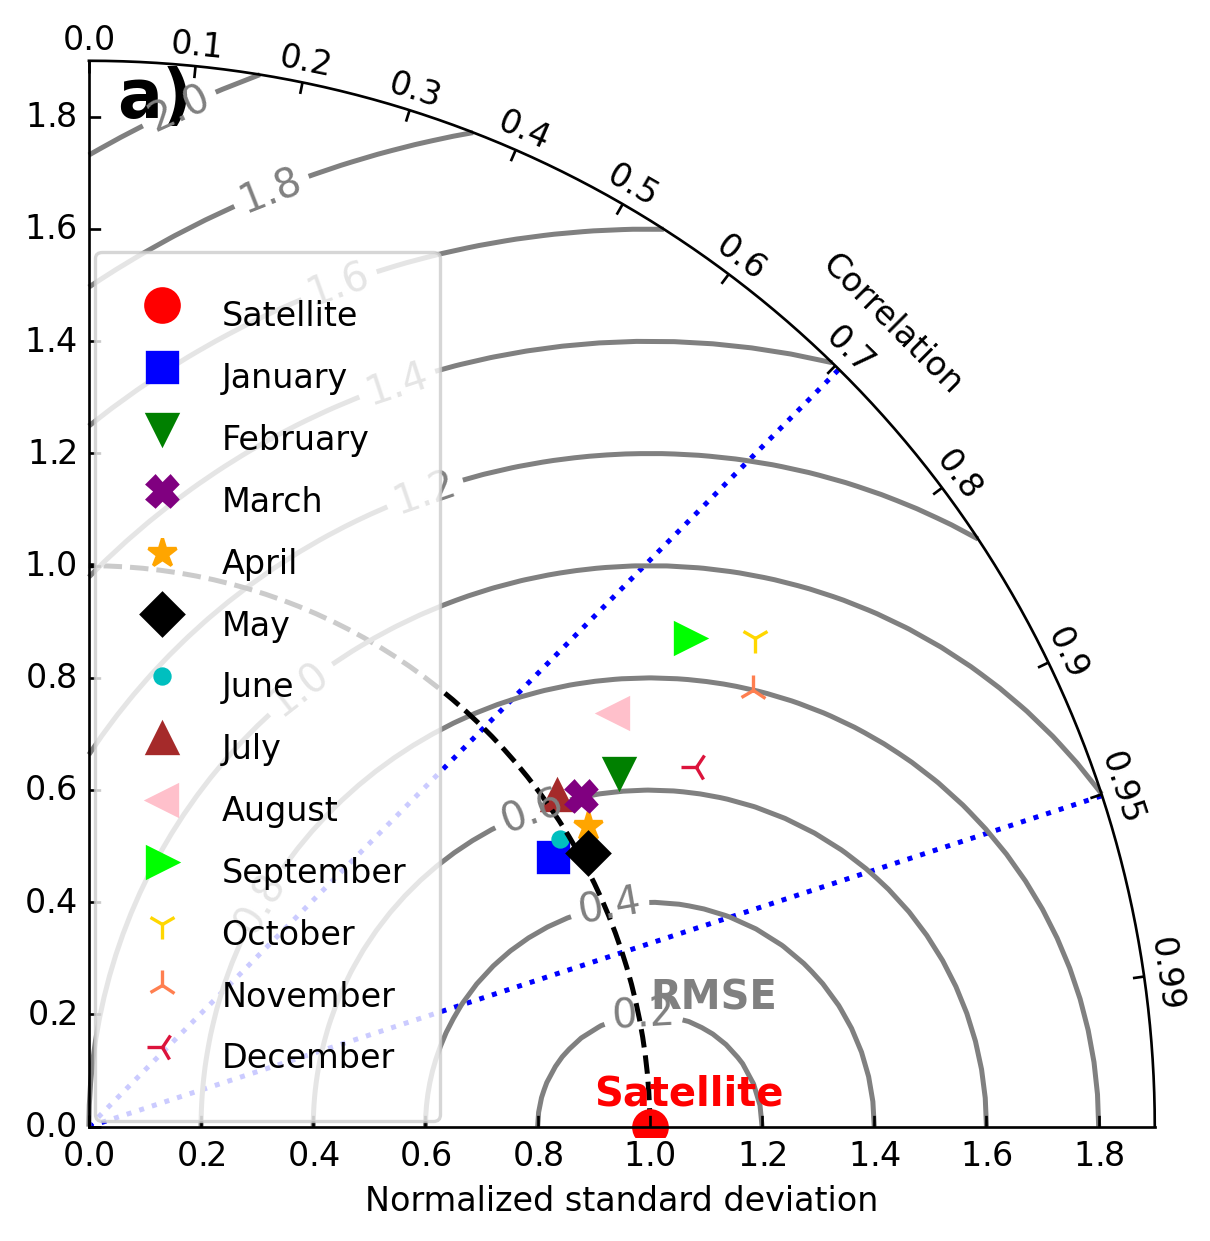

In [27]:
import numpy as NP
figID_Taylor = plt.figure(num=25, dpi=240)
figID_Taylor.set_size_inches(6., 6.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0, 1.9), label='Satellite')
ttt=TayDia.add_sample(STD_1, CORR_1, marker='s', linestyle='None', color='b', ms=9,label='January')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_2, CORR_2, marker='v', linestyle='None', color='g', ms=9,label='February')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_3, CORR_3, marker='X', linestyle='None', color='purple', ms=9,label='March')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_4, CORR_4, marker='*', linestyle='None', color='orange', ms=9,label='April')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_5, CORR_5, marker='D', linestyle='None', color='k', ms=9,label='May')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_6, CORR_6, marker='.', linestyle='None', color='c', ms=9,label='June')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_7, CORR_7, marker='^', linestyle='None', color='brown', ms=9,label='July')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_8, CORR_8, marker='<', linestyle='None', color='pink', ms=9,label='August')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_9, CORR_9, marker='>', linestyle='None', color='lime', ms=9,label='September')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_10, CORR_10, marker='1', linestyle='None', color='gold', ms=9,label='October')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_11, CORR_11, marker='2', linestyle='None', color='coral', ms=9,label='November')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_12, CORR_12, marker='3', linestyle='None', color='crimson', ms=9,label='December')#, ax=axs.ravel()[i])
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=12, fmt='%.1f')
plt.legend(prop=dict(size='medium'), loc='lower left',borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05)
#plt.legend(label='JAN',  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.90,0.04,'Satellite', color='red',weight='bold',fontsize=12)
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'a)', color='black',weight='bold', fontsize=20)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold',fontsize=12)

In [ ]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'OCEAN COLOUR', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'a)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# California

## Datos Reanalisis

In [ ]:
t_ini=np.datetime64('1998-01-01T12:00:00.000000000')
t_fin= np.datetime64('2019-12-31T12:00:00.000000000')
print(t_ini,t_fin)

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_BIO/California/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_BIO.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R 

## Datos SeaWifs

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/OCEAN_COLOUR_VALIDACION_CLOROFILA/California/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_COLOUR_CHL.nc')
S 

**Traer las fechas**

In [ ]:
ds.time.values

In [ ]:
S=S.assign_coords({"time": ds.time.values})
S

In [ ]:
# Agrupacion mensual
S2 = {g[0]:g[1] for g in S.groupby('time.month')}
print(S2.keys())

In [ ]:
S2[1] # bien funciona

In [ ]:
plt.imshow(S2[1].isel(time=0).CHL.values,cmap='jet')# ya tiene aplicado log10
plt.colorbar()

**Interpolacion de Reanalisis a los tiempos de SeaWifs**

In [ ]:
# Interpolacion a tiempos de SeaWifs
R1=R.interp(time=S.time.values, method='linear')
R1

In [ ]:
# Agrupacion mensual
R2 = {g[0]:g[1] for g in R1.groupby('time.month')}
print(R2.keys())

In [ ]:
R2[1] # por ejemplo sacar el mes 1

In [ ]:
plt.imshow(np.flipud(np.log10(R2[1].isel(time=1).chl.values)),cmap='jet') # tiempo tiene que ser de uno en adelante
plt.colorbar()

## Grafico de sesgo

In [ ]:
x1=R2[1].lon.values-360
y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
z= np.flipud(np.mean(R2[1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[1].CHL.values[1:,:,:],axis=0))

In [ ]:
m=Basemap(projection='cyl',llcrnrlon=-130,llcrnrlat=20,urcrnrlon=-110,urcrnrlat=50, resolution ='c')
m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)

In [ ]:
import string
ticks= np.array([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]) #labels para el colorbar
x1=R2[1].lon.values-360;y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-130,llcrnrlat=20,urcrnrlon=-110,urcrnrlat=50, resolution ='h')
  x, y = m(x1, y1)
  z= np.flipud(np.mean(R2[j+1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[j+1].CHL.values[1:,:,:],axis=0))
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(20,50+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-130,-125,-120,-115, -110],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias Chla $mg m^{-3}$', rotation=90)

## Calculos previos de validacion

In [ ]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [ ]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
dfr.to_csv('Datos_Taylor_Validacion_Clorofila_California.csv',index=False)

## Diagrama de Taylor

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

In [22]:
dfr=pd.read_csv('Datos_Taylor_Validacion_Clorofila_California.csv')
import matplotlib.pyplot as plt
STD_m =list(dfr.STD)
CORRCOEF =list(dfr.CORR)
RMSE=list(dfr.RMSE)
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
dfr

,STD,CORR,RMSE,Mes
0,1.255673,0.871484,0.807967,January
1,0.985059,0.904391,0.436665,February
2,1.096507,0.879299,0.554437,March
3,1.363719,0.843518,0.826536,April
4,1.364834,0.822149,0.831615,May
5,1.153752,0.835097,0.642555,June
6,0.973690,0.822283,0.589815,July
7,0.910850,0.798065,0.623422,August
8,0.908073,0.804452,0.624648,September
9,0.955978,0.839847,0.600437,October


In [23]:
STD_1,STD_2,STD_3,STD_4,STD_5,STD_6,STD_7,STD_8,STD_9,STD_10,STD_11,STD_12= dfr.STD.values
CORR_1,CORR_2,CORR_3,CORR_4,CORR_5,CORR_6,CORR_7,CORR_8,CORR_9,CORR_10,CORR_11,CORR_12= dfr.CORR.values
RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8,RMSE_9,RMSE_10,RMSE_11,RMSE_12= dfr.RMSE.values

Text(1.0, 0.21, 'RMSE')

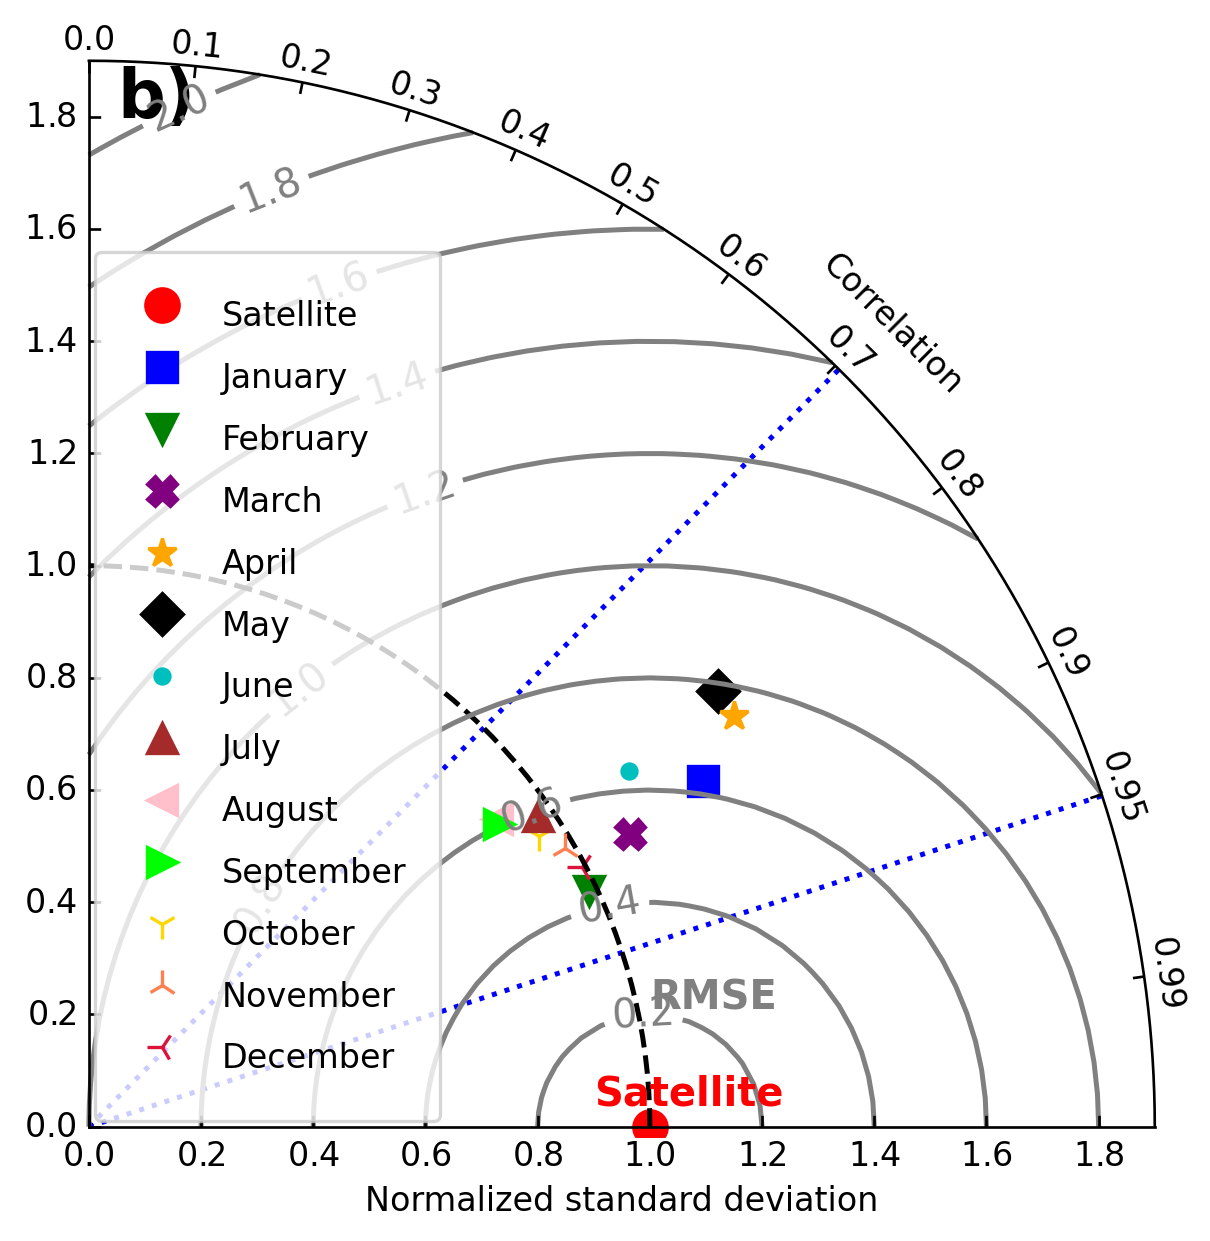

In [24]:
import numpy as NP
figID_Taylor = plt.figure(num=25, dpi=240)
figID_Taylor.set_size_inches(6., 6.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0, 1.9), label='Satellite')
ttt=TayDia.add_sample(STD_1, CORR_1, marker='s', linestyle='None', color='b', ms=9,label='January')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_2, CORR_2, marker='v', linestyle='None', color='g', ms=9,label='February')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_3, CORR_3, marker='X', linestyle='None', color='purple', ms=9,label='March')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_4, CORR_4, marker='*', linestyle='None', color='orange', ms=9,label='April')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_5, CORR_5, marker='D', linestyle='None', color='k', ms=9,label='May')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_6, CORR_6, marker='.', linestyle='None', color='c', ms=9,label='June')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_7, CORR_7, marker='^', linestyle='None', color='brown', ms=9,label='July')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_8, CORR_8, marker='<', linestyle='None', color='pink', ms=9,label='August')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_9, CORR_9, marker='>', linestyle='None', color='lime', ms=9,label='September')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_10, CORR_10, marker='1', linestyle='None', color='gold', ms=9,label='October')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_11, CORR_11, marker='2', linestyle='None', color='coral', ms=9,label='November')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_12, CORR_12, marker='3', linestyle='None', color='crimson', ms=9,label='December')#, ax=axs.ravel()[i])
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=12, fmt='%.1f')
plt.legend(prop=dict(size='medium'), loc='lower left',borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05)
#plt.legend(label='JAN',  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.90,0.04,'Satellite', color='red',weight='bold',fontsize=12)
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'b)', color='black',weight='bold', fontsize=20)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold',fontsize=12)

In [ ]:
np.ma.std(A.ravel())

In [ ]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'OCEAN COLOUR', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'b)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# Canarias

## Datos Reanalisis

In [ ]:
t_ini=np.datetime64('1998-01-01T12:00:00.000000000')
t_fin= np.datetime64('2019-12-31T12:00:00.000000000')
print(t_ini,t_fin)

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_BIO/Canarias/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_BIO.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R 

## Datos SeaWifs

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/OCEAN_COLOUR_VALIDACION_CLOROFILA/Canarias/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_COLOUR_CHL.nc')
S 

**Traer las fechas**

In [ ]:
ds.time.values

In [ ]:
S=S.assign_coords({"time": ds.time.values})
S

In [ ]:
# Agrupacion mensual
S2 = {g[0]:g[1] for g in S.groupby('time.month')}
print(S2.keys())

In [ ]:
S2[1] # bien funciona

In [ ]:
plt.imshow(S2[1].isel(time=0).CHL.values,cmap='jet')# ya tiene aplicado log10
plt.colorbar()

**Interpolacion de Reanalisis a los tiempos de SeaWifs**

In [ ]:
# Interpolacion a tiempos de SeaWifs
R1=R.interp(time=S.time.values, method='linear')
R1

In [ ]:
# Agrupacion mensual
R2 = {g[0]:g[1] for g in R1.groupby('time.month')}
print(R2.keys())

In [ ]:
R2[1] # por ejemplo sacar el mes 1

In [ ]:
plt.imshow(np.flipud(np.log10(R2[1].isel(time=1).chl.values)),cmap='jet') # tiempo tiene que ser de uno en adelante
plt.colorbar()

## Grafico de sesgo

In [ ]:
x1=R2[1].lon.values-360
y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
z= np.flipud(np.mean(R2[1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[1].CHL.values[1:,:,:],axis=0))

In [ ]:
m=Basemap(projection='cyl',llcrnrlon=-25,llcrnrlat=15,urcrnrlon=-5,urcrnrlat=45, resolution ='c')
m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)

In [ ]:
import string
ticks= np.array([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]) #labels para el colorbar
x1=R2[1].lon.values-360;y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=-25,llcrnrlat=15,urcrnrlon=-5,urcrnrlat=45, resolution ='h')
  x, y = m(x1, y1)
  z= np.flipud(np.mean(R2[j+1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[j+1].CHL.values[1:,:,:],axis=0))
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(15,45+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([-25,-20,-15,-10,-5],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias Chla $mg m^{-3}$', rotation=90)

## Calculos previos de validacion

In [ ]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [ ]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
dfr.to_csv('Datos_Taylor_Validacion_Clorofila_Canarias.csv',index=False)

## Diagrama de Taylor

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

In [19]:
dfr=pd.read_csv('Datos_Taylor_Validacion_Clorofila_Canarias.csv')
import matplotlib.pyplot as plt
STD_m =list(dfr.STD)
CORRCOEF =list(dfr.CORR)
RMSE=list(dfr.RMSE)
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
dfr

,STD,CORR,RMSE,Mes
0,1.554991,0.744574,1.346385,January
1,1.204367,0.851383,0.748319,February
2,1.235993,0.852922,0.669287,March
3,1.507102,0.827711,1.004075,April
4,1.473939,0.801465,1.332538,May
5,1.226949,0.837746,1.270465,June
6,0.918909,0.770647,0.990118,July
7,0.693616,0.722482,0.798968,August
8,0.634028,0.796779,0.663626,September
9,0.728681,0.914598,0.482032,October


In [20]:
STD_1,STD_2,STD_3,STD_4,STD_5,STD_6,STD_7,STD_8,STD_9,STD_10,STD_11,STD_12= dfr.STD.values
CORR_1,CORR_2,CORR_3,CORR_4,CORR_5,CORR_6,CORR_7,CORR_8,CORR_9,CORR_10,CORR_11,CORR_12= dfr.CORR.values
RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8,RMSE_9,RMSE_10,RMSE_11,RMSE_12= dfr.RMSE.values

Text(1.0, 0.21, 'RMSE')

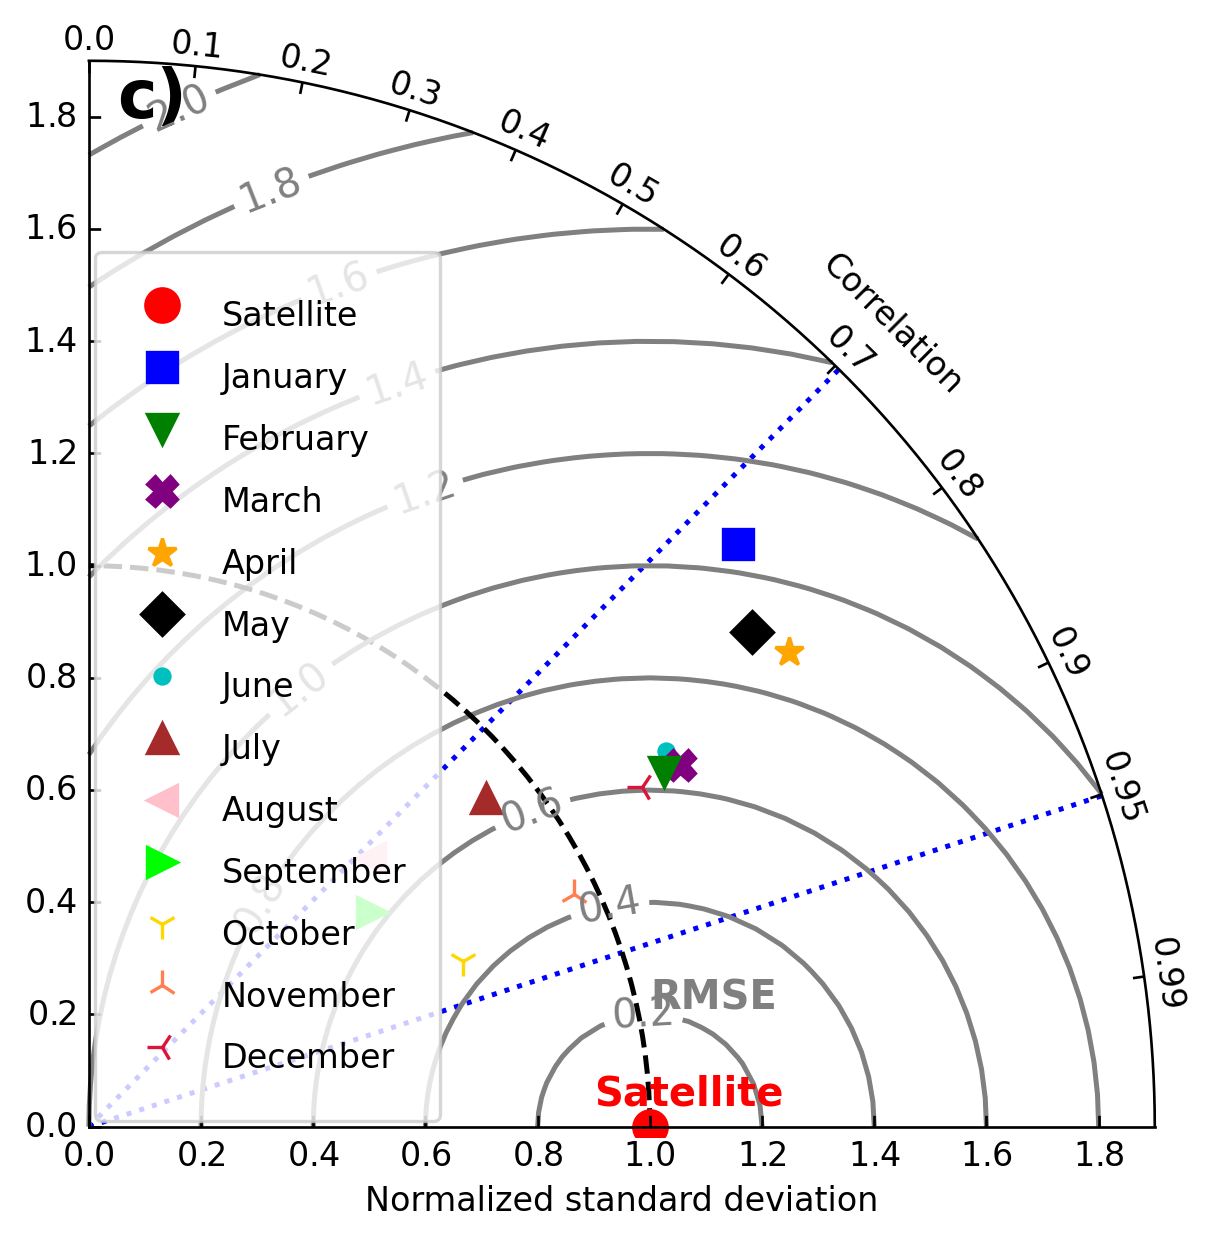

In [21]:
import numpy as NP
figID_Taylor = plt.figure(num=25, dpi=240)
figID_Taylor.set_size_inches(6., 6.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0, 1.9), label='Satellite')
ttt=TayDia.add_sample(STD_1, CORR_1, marker='s', linestyle='None', color='b', ms=9,label='January')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_2, CORR_2, marker='v', linestyle='None', color='g', ms=9,label='February')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_3, CORR_3, marker='X', linestyle='None', color='purple', ms=9,label='March')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_4, CORR_4, marker='*', linestyle='None', color='orange', ms=9,label='April')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_5, CORR_5, marker='D', linestyle='None', color='k', ms=9,label='May')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_6, CORR_6, marker='.', linestyle='None', color='c', ms=9,label='June')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_7, CORR_7, marker='^', linestyle='None', color='brown', ms=9,label='July')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_8, CORR_8, marker='<', linestyle='None', color='pink', ms=9,label='August')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_9, CORR_9, marker='>', linestyle='None', color='lime', ms=9,label='September')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_10, CORR_10, marker='1', linestyle='None', color='gold', ms=9,label='October')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_11, CORR_11, marker='2', linestyle='None', color='coral', ms=9,label='November')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_12, CORR_12, marker='3', linestyle='None', color='crimson', ms=9,label='December')#, ax=axs.ravel()[i])
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=12, fmt='%.1f')
plt.legend(prop=dict(size='medium'), loc='lower left',borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05)
#plt.legend(label='JAN',  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.90,0.04,'Satellite', color='red',weight='bold',fontsize=12)
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'c)', color='black',weight='bold', fontsize=20)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold',fontsize=12)

In [ ]:
np.ma.std(A.ravel())

In [ ]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':') # correlacion 0.95
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'OCEAN COLOUR', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'c)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')

# Benguela

## Datos Reanalisis

In [ ]:
t_ini=np.datetime64('1998-01-01T12:00:00.000000000')
t_fin= np.datetime64('2019-12-31T12:00:00.000000000')
print(t_ini,t_fin)

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/GLOBAL_REANALYSIS_BIO/Benguela/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
R=xr.open_dataset('GLOBAL_REANALYSIS_BIO.nc')
R=R.where((R.time >=t_ini)&(R.time <= t_fin),drop=True)
R 

## Datos SeaWifs

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/OCEAN_COLOUR_VALIDACION_CLOROFILA/Benguela/Data_anual/'
#QS=xr.open_dataset('QuickSCAT_Wind_Caribe_1degx1deg.nc')
S=xr.open_dataset('GLOBAL_COLOUR_CHL.nc')
S 

**Traer las fechas**

In [ ]:
ds.time.values

In [ ]:
S=S.assign_coords({"time": ds.time.values})
S

In [ ]:
# Agrupacion mensual
S2 = {g[0]:g[1] for g in S.groupby('time.month')}
print(S2.keys())

In [ ]:
S2[1] # bien funciona

In [ ]:
plt.imshow(S2[1].isel(time=0).CHL.values,cmap='jet')# ya tiene aplicado log10
plt.colorbar()

**Interpolacion de Reanalisis a los tiempos de SeaWifs**

In [ ]:
# Interpolacion a tiempos de SeaWifs
R1=R.interp(time=S.time.values, method='linear')
R1

In [ ]:
# Agrupacion mensual
R2 = {g[0]:g[1] for g in R1.groupby('time.month')}
print(R2.keys())

In [ ]:
R2[1] # por ejemplo sacar el mes 1

In [ ]:
plt.imshow(np.flipud(np.log10(R2[1].isel(time=1).chl.values)),cmap='jet') # tiempo tiene que ser de uno en adelante
plt.colorbar()

## Grafico de sesgo

In [ ]:
x1=R2[1].lon.values-360
y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
z= np.flipud(np.mean(R2[1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[1].CHL.values[1:,:,:],axis=0))

In [ ]:
!pip install cmocean
import cmocean

In [ ]:
m=Basemap(projection='cyl',llcrnrlon=5,llcrnrlat=-40,urcrnrlon=25,urcrnrlat=-10, resolution ='c')
m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)

In [ ]:
import string
ticks= np.array([-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5,3]) #labels para el colorbar
x1=R2[1].lon.values-360;y1=R2[1].lat.values;y1=y1[::-1];y1= np.array(y1);
w=0.23;h=0.17
meses=['January','February','March','April','May','June','July','August','September','October','November','December']
# atributos [left, bottom, width,height] en escala (0,1)
list_o=[[0,0.9,w,h],[0.2,0.9,w,h],[0.4,0.9,w,h],[0.6,0.9,w,h],
        [0,0.70,w,h],[0.2,0.7,w,h],[0.4,0.7,w,h],[0.6,0.7,w,h],
        [0,0.5,w,h],[0.2,0.5,w,h],[0.4,0.5,w,h],[0.6,0.5,w,h],]
fig = plt.figure(figsize=(3.3*5.1,4.7*4.7)) # tamaño de figura
for i,j in zip(list_o,range(12)):
  ax = plt.axes(i)
  ax.text(0.,1.01,string.ascii_lowercase[j]+')',fontsize=20, fontweight = 'bold', transform = ax.transAxes)
  ax.set_title(meses[j], fontsize=15)
  m=Basemap(projection='cyl',llcrnrlon=5,llcrnrlat=-40,urcrnrlon=25,urcrnrlat=-10, resolution ='h')
  x, y = m(x1, y1)
  z= np.flipud(np.mean(R2[j+1].chl.values[1:,:,:], axis=0))-(10**np.mean(S2[j+1].CHL.values[1:,:,:],axis=0))
  cmap= plt.get_cmap("jet")
  cs=m.pcolormesh(x1, y1, z,cmap=cmocean.cm.balance,shading='flat',latlon=True,vmin=-3, vmax=3)
  m.drawcoastlines(color='white',zorder=0)
  m.fillcontinents(color='grey',lake_color='grey')
  m.drawparallels(np.arange(-40,-10+1,5.),labels=[1,0,0,0],linewidth=0.0)
  m.drawmeridians([5,10,15,20,25],labels=[0,0,0,1],linewidth=0.0)
  if j in [3,7,11]:
    cbar=plt.colorbar(ticks=ticks)
    cbar.set_label('Bias Chla $mg m^{-3}$', rotation=90)

## Calculos previos de validacion

In [ ]:
STD_m =[]
CORRCOEF = []
RMSE=[]
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
for k in range(1,12+1,1):
  # Extraccion de datos de modelo y satelite
  modelo= np.flipud(np.mean(np.log10(R2[k].chl.values[1:,:,:]), axis=0))# aplicar media en dimension tiempo
  satelite= np.mean(S2[k].CHL.values[1:,:,:],axis=0) # aplicar media en dimension tiempo
  # Sacar los indices que comparten en el espacio
  IND = np.invert(np.isnan(satelite) | np.isnan(modelo))
  P = modelo[IND] # Modelo
  A = satelite[IND] # Referencia Era
  DD = np.ma.std(A.ravel()) # Desviacion estandar Referencia
  P = P/DD # Normalizacion por Std referencia
  A = A/DD 
  STD_m.append(np.ma.std(P.ravel()))
  CORRCOEF.append(np.ma.corrcoef(P.ravel(), A.ravel()).data[0,1])
  RMSE.append(np.sqrt(np.mean((P-A)**2)))

In [ ]:
dfr=pd.DataFrame({'STD':STD_m,'CORR':CORRCOEF,'RMSE':RMSE,'Mes':Meses})
dfr

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
dfr.to_csv('Datos_Taylor_Validacion_Clorofila_Benguela.csv',index=False)

## Diagrama de Taylor

In [ ]:
%cd '/content/gdrive/MyDrive/Doctorado Tesis/Scripts/SOM/'
from taylorDiagram_mod import TaylorDiagram as TaDiM

In [16]:
dfr=pd.read_csv('Datos_Taylor_Validacion_Clorofila_Benguela.csv')
import matplotlib.pyplot as plt
STD_m =list(dfr.STD)
CORRCOEF =list(dfr.CORR)
RMSE=list(dfr.RMSE)
Meses=['January','February','March','April','May','June','July','August','September','October','November','December']
COLORES = plt.cm.get_cmap('nipy_spectral', 24)
MARCADORES = ['s', 'v', 'X', '*', 'D','.','^','<','>','1','2','3','4','8','p','P','h','H','d']
dfr

,STD,CORR,RMSE,Mes
0,0.947097,0.804258,0.689195,January
1,1.221073,0.726579,1.065045,February
2,1.200390,0.782136,0.806064,March
3,1.060978,0.763467,0.737089,April
4,0.890934,0.791286,0.843159,May
5,0.782613,0.801428,0.898355,June
6,0.738560,0.821500,0.890166,July
7,0.771680,0.795351,0.934090,August
8,0.782576,0.698778,0.963449,September
9,0.845816,0.617853,0.885972,October


In [17]:
STD_1,STD_2,STD_3,STD_4,STD_5,STD_6,STD_7,STD_8,STD_9,STD_10,STD_11,STD_12= dfr.STD.values
CORR_1,CORR_2,CORR_3,CORR_4,CORR_5,CORR_6,CORR_7,CORR_8,CORR_9,CORR_10,CORR_11,CORR_12= dfr.CORR.values
RMSE_1,RMSE_2,RMSE_3,RMSE_4,RMSE_5,RMSE_6,RMSE_7,RMSE_8,RMSE_9,RMSE_10,RMSE_11,RMSE_12= dfr.RMSE.values

Text(1.0, 0.21, 'RMSE')

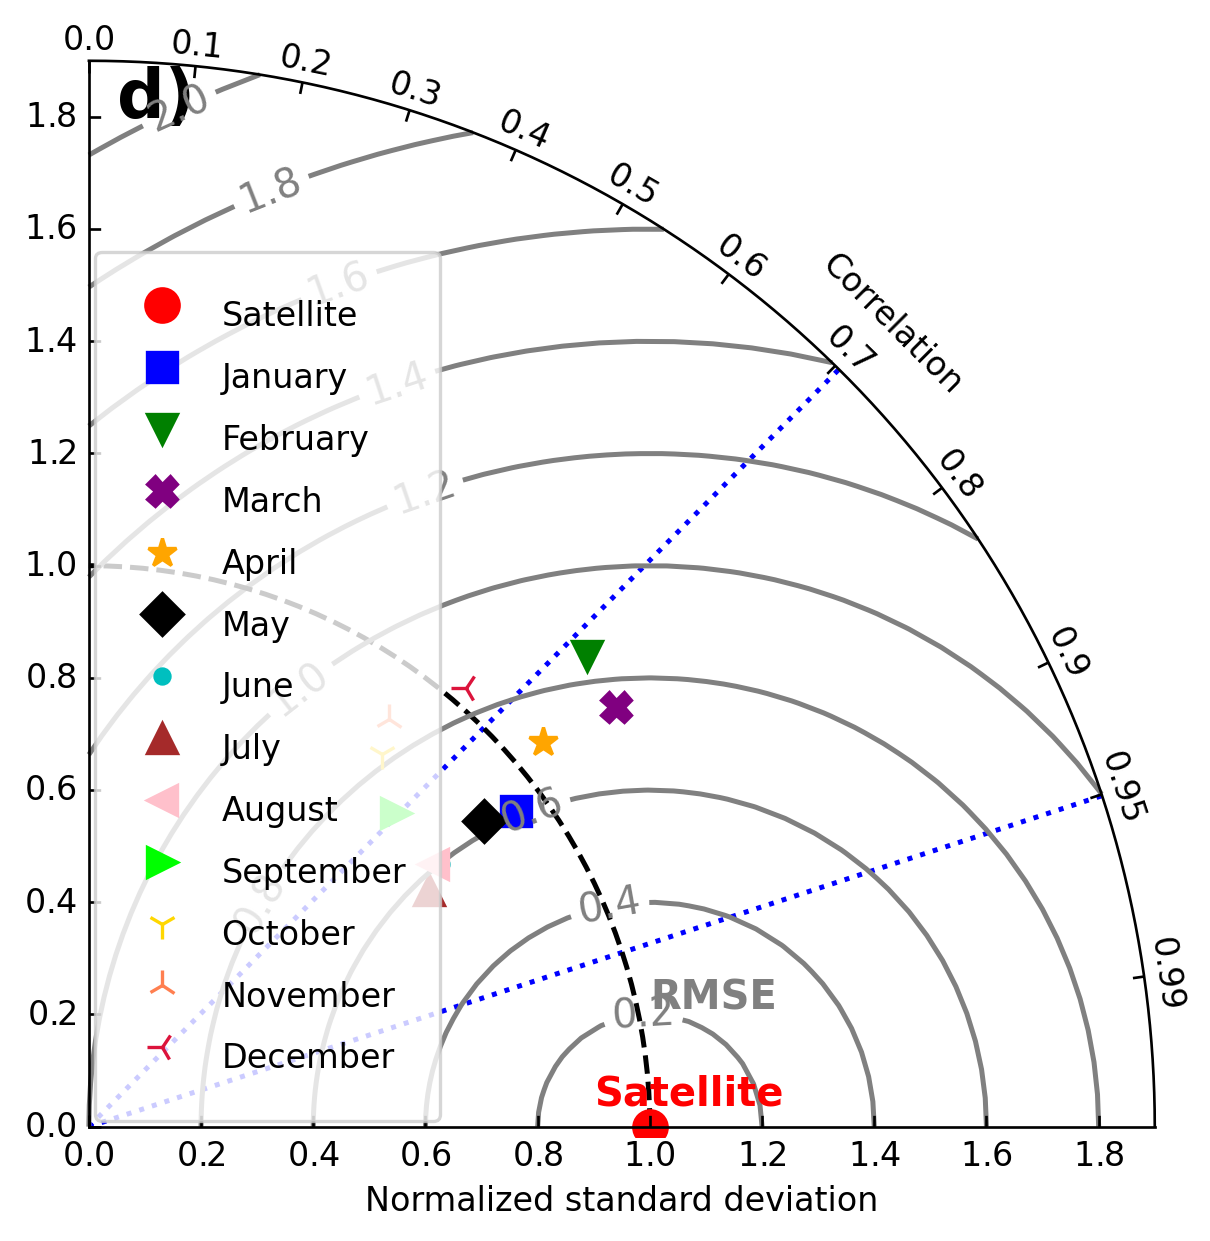

In [18]:
import numpy as NP
figID_Taylor = plt.figure(num=25, dpi=240)
figID_Taylor.set_size_inches(6., 6.)
TayDia = TaDiM(1, fig=figID_Taylor, rect=111, srange=(0, 1.9), label='Satellite')
ttt=TayDia.add_sample(STD_1, CORR_1, marker='s', linestyle='None', color='b', ms=9,label='January')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_2, CORR_2, marker='v', linestyle='None', color='g', ms=9,label='February')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_3, CORR_3, marker='X', linestyle='None', color='purple', ms=9,label='March')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_4, CORR_4, marker='*', linestyle='None', color='orange', ms=9,label='April')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_5, CORR_5, marker='D', linestyle='None', color='k', ms=9,label='May')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_6, CORR_6, marker='.', linestyle='None', color='c', ms=9,label='June')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_7, CORR_7, marker='^', linestyle='None', color='brown', ms=9,label='July')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_8, CORR_8, marker='<', linestyle='None', color='pink', ms=9,label='August')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_9, CORR_9, marker='>', linestyle='None', color='lime', ms=9,label='September')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_10, CORR_10, marker='1', linestyle='None', color='gold', ms=9,label='October')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_11, CORR_11, marker='2', linestyle='None', color='coral', ms=9,label='November')#, ax=axs.ravel()[i])
ttt=TayDia.add_sample(STD_12, CORR_12, marker='3', linestyle='None', color='crimson', ms=9,label='December')#, ax=axs.ravel()[i])
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':')
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=12, fmt='%.1f')
plt.legend(prop=dict(size='medium'), loc='lower left',borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05)
#plt.legend(label='JAN',  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.90,0.04,'Satellite', color='red',weight='bold',fontsize=12)
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'d)', color='black',weight='bold', fontsize=20)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold',fontsize=12)

In [ ]:
np.ma.std(A.ravel())

In [ ]:
import numpy as NP
figID_Taylor = plt.figure(num=11, dpi=80)
figID_Taylor.set_size_inches(7., 7.)
TayDia = TaDiM(np.ma.std(A.ravel()), fig=figID_Taylor, rect=111, srange=(0., 1.9), label='Ocean Colour')
pp=[]
for i in range(11+1):
  ttt=TayDia.add_sample(STD_m[i], CORRCOEF[i], marker=MARCADORES[i%len(MARCADORES)], linestyle='None', color=COLORES(i), ms=8)#, ax=axs.ravel()[i])
  pp.append(ttt)
contours = TayDia.add_contours(levels=10, colors='0.5')
plt.plot([0,NP.sqrt(1.9**2 -0.59**2)],[0,0.59], color='blue',linestyle=':') # correlacion 0.95
plt.plot([0,NP.sqrt(1.9**2 -1.35**2)],[0,1.35], color='blue',linestyle=':') # correlacion 0.70
TayDia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
plt.legend(pp, Meses,  prop=dict(size='small'), loc='lower left', borderpad=1.0, ncol=1,handleheight=2.4, labelspacing=0.05) # numpoints=1,
plt.text(0.85,0.04,'OCEAN COLOUR', color='red',weight='bold')
#plt.text(0.85,0.35,'MMM', color='red',weight='bold')
plt.text(0.05,1.8,'d)', color='black',weight='bold', fontsize=18)
plt.text(1.00,0.21,'RMSE', color='gray',weight='bold')